<a href="https://colab.research.google.com/github/sonalisanjeevprabu18/Neural-Network-and-Deep-Learning/blob/main/Sparse_Autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Epoch 1, Loss: 29.2314
Epoch 2, Loss: 17.3221
Epoch 3, Loss: 14.7357
Epoch 4, Loss: 13.2221
Epoch 5, Loss: 12.2035


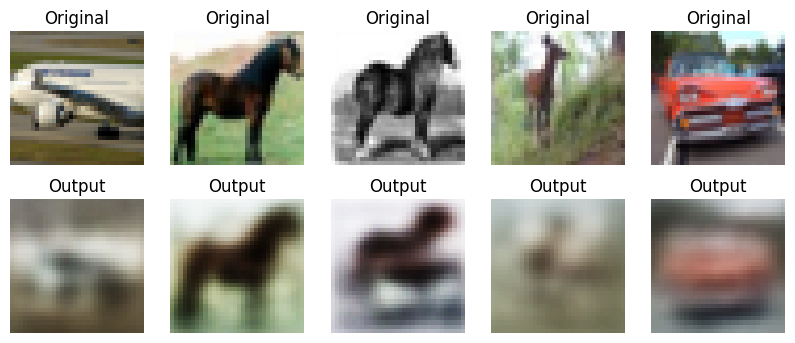

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
transform = transforms.Compose([
    transforms.ToTensor()
])
train_loader = torch.utils.data.DataLoader(
    datasets.CIFAR10(root='./data', train=True, download=True, transform=transform),
    batch_size=64,
    shuffle=True
)
class SparseAutoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Linear(3072, 256)
        self.decoder = nn.Linear(256, 3072)
        self.activation = nn.Sigmoid()

    def forward(self, x):
        hidden = self.activation(self.encoder(x))
        output = self.activation(self.decoder(hidden))
        return hidden, output
def kl_divergence(rho, rho_hat):
    return torch.sum(
        rho * torch.log(rho / rho_hat) +
        (1 - rho) * torch.log((1 - rho) / (1 - rho_hat))
    )
model = SparseAutoencoder()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
rho = 0.05
beta = 0.001
epochs = 5
for epoch in range(epochs):
    total_loss = 0
    for data, _ in train_loader:
        data = data.view(-1, 3072)

        hidden, output = model(data)

        recon_loss = criterion(output, data)
        rho_hat = torch.mean(hidden, dim=0)
        sparse_loss = kl_divergence(rho, rho_hat)

        loss = recon_loss + beta * sparse_loss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch+1}, Loss: {total_loss:.4f}")
# Get one batch
data, _ = next(iter(train_loader))
data_flat = data.view(-1, 32*32*3)

# Reconstruct
_, reconstructed = model(data_flat)

# Reshape back to image format
data = data[:5]
reconstructed = reconstructed[:5].view(-1, 3, 32, 32)

# Plot
plt.figure(figsize=(10,4))

for i in range(5):
    # Original
    plt.subplot(2,5,i+1)
    plt.imshow(data[i].permute(1,2,0))
    plt.title("Original")
    plt.axis("off")

    # Reconstructed
    plt.subplot(2,5,i+6)
    plt.imshow(reconstructed[i].detach().permute(1,2,0))
    plt.title("Output")
    plt.axis("off")

plt.show()
